In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import label_binarize
import seaborn as sns


In [32]:
# Path directories of the dataset
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
train_no_dir = os.path.join(parent_dir, 'common_test', 'dataset', 'train', 'no')
train_sphere_dir = os.path.join(parent_dir, 'common_test', 'dataset', 'train', 'sphere')
train_vort_dir = os.path.join(parent_dir, 'common_test', 'dataset', 'train', 'vort')
val_no_dir = os.path.join(parent_dir, 'common_test', 'dataset', 'val', 'no')
val_sphere_dir = os.path.join(parent_dir, 'common_test', 'dataset', 'val', 'sphere')
val_vort_dir = os.path.join(parent_dir, 'common_test', 'dataset', 'val', 'vort')


In [33]:
# Function to load data from directories
def load_data_from_dir(directory):
    files = os.listdir(directory)
    data_list = []
    for file in files:
        if file.endswith('.npy'):
            file_path = os.path.join(directory, file)
            data = np.load(file_path)
            data_list.append(data)
    return np.array(data_list)


In [34]:
# Load the data
train_no = load_data_from_dir(train_no_dir)
train_sphere = load_data_from_dir(train_sphere_dir)
train_vort = load_data_from_dir(train_vort_dir)
val_no = load_data_from_dir(val_no_dir)
val_sphere = load_data_from_dir(val_sphere_dir)
val_vort = load_data_from_dir(val_vort_dir)

In [35]:
print(f"Loaded {len(train_no)} no training samples")
print(f"Loaded {len(train_sphere)} sphere training samples")
print(f"Loaded {len(train_vort)} vort training samples")
print(f"Loaded {len(val_no)} no validation samples")
print(f"Loaded {len(val_sphere)} sphere validation samples")
print(f"Loaded {len(val_vort)} vort validation samples")

Loaded 10000 no training samples
Loaded 10000 sphere training samples
Loaded 10000 vort training samples
Loaded 2500 no validation samples
Loaded 2500 sphere validation samples
Loaded 2500 vort validation samples


In [36]:
# Check the shape of a single data point to better understand data structure
if len(train_no) > 0:
    print(f"Shape of a single data point: {train_no[0].shape}")

Shape of a single data point: (1, 150, 150)


In [37]:
# If needed, reshape data to have a channel dimension
def prepare_data(data_array):
    # Check the dimensionality
    sample_shape = data_array[0].shape
    
    # If the data is already 3D (height, width, channels), no reshaping needed
    if len(sample_shape) == 3:
        return data_array
    # If the data is 2D (height, width), add a channel dimension
    elif len(sample_shape) == 2:
        return np.expand_dims(data_array, axis=-1)
    else:
        raise ValueError(f"Unexpected data shape: {sample_shape}")

In [38]:
# Prepare data (add channel dimension if needed)
train_no = prepare_data(train_no)
train_sphere = prepare_data(train_sphere)
train_vort = prepare_data(train_vort)
val_no = prepare_data(val_no)
val_sphere = prepare_data(val_sphere)
val_vort = prepare_data(val_vort)

In [39]:
# Labels: 0 for 'no', 1 for 'sphere', 2 for 'vort'
train_no_labels = np.zeros(len(train_no))
train_sphere_labels = np.ones(len(train_sphere))
train_vort_labels = np.full(len(train_vort), 2)

val_no_labels = np.zeros(len(val_no))
val_sphere_labels = np.ones(len(val_sphere))
val_vort_labels = np.full(len(val_vort), 2)

In [40]:
X_train = np.concatenate((train_no, train_sphere, train_vort), axis=0)
y_train = np.concatenate((train_no_labels, train_sphere_labels, train_vort_labels), axis=0)

X_val = np.concatenate((val_no, val_sphere, val_vort), axis=0)
y_val = np.concatenate((val_no_labels, val_sphere_labels, val_vort_labels), axis=0)

In [41]:
# Save the original labels for ROC curve calculation
y_train_orig = y_train.copy()
y_val_orig = y_val.copy()

In [42]:
# Convert to one-hot encoding
y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)


In [43]:
# Normalize the data (scale to [0, 1])
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0


In [44]:
# Print final dataset shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (30000, 1, 150, 150)
y_train shape: (30000, 3)
X_val shape: (7500, 1, 150, 150)
y_val shape: (7500, 3)


In [45]:
# #shuffling train data
# indices = np.random.permutation(len(y_train))
# X_train, y_train = X_train[indices], y_train[indices]

# #shuffling val data
# indices = np.random.permutation(len(y_val))
# X_val, y_val = X_val[indices], y_val[indices]

In [46]:
def create_model(input_shape):
    # Extract height, width, channels
    height, width, channels = input_shape
    
    model = Sequential()
    
    # First convolutional block - adjust pooling based on height
    model.add(Conv2D(32, (1, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (1, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    # Only pool along width dimension if height is 1
    if height == 1:
        model.add(MaxPooling2D(pool_size=(1, 2)))
    else:
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Second convolutional block
    model.add(Conv2D(64, (1, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (1, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    # Only pool along width dimension if height is 1
    if height == 1:
        model.add(MaxPooling2D(pool_size=(1, 2)))
    else:
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Third convolutional block
    model.add(Conv2D(128, (1, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (1, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    # Only pool along width dimension if height is 1
    if height == 1:
        model.add(MaxPooling2D(pool_size=(1, 2)))
    else:
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))  # 3 classes
    
    # Compile with AUC metric
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.AUC()]
    )
    
    return model

In [47]:
input_shape = X_train[0].shape
print(f"Input shape for the model: {input_shape}")

Input shape for the model: (1, 150, 150)


In [48]:
# Create the model
model = create_model(input_shape)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 1, 150, 32)     │        14,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 1, 150, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 1, 150, 32)     │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 1, 150, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 1, 75, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 75, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 1, 75, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 1, 75, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 1, 75, 64)      │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 1, 75, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 37, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 37, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 1, 37, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1, 37, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 1, 37, 128)     │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 1, 37, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 18, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 18, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 703,747 (2.68 MB)

 Trainable params: 702,339 (2.68 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [49]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [50]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=(reduce_lr, early_stop)
)


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.3406 - auc_2: 0.5053 - loss: 1.5402 - val_accuracy: 0.3333 - val_auc_2: 0.5045 - val_loss: 1.9877 - learning_rate: 0.0010
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.3347 - auc_2: 0.4997 - loss: 1.1302 - val_accuracy: 0.3312 - val_auc_2: 0.4968 - val_loss: 1.1052 - learning_rate: 0.0010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.3426 - auc_2: 0.5074 - loss: 1.1098 - val_accuracy: 0.3475 - val_auc_2: 0.5135 - val_loss: 1.1099 - learning_rate: 0.0010
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.3370 - auc_2: 0.5040 - loss: 1.1099 - val_accuracy: 0.3216 - val_auc_2: 0.4858 - val_loss: 1.1089 - learning_rate: 0.0010
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.3377 - auc_2: 0.5035 - loss: 1.1105 - val_accuracy: 0.3415 - val_auc_2: 0.5113 - val_loss: 1.1011 - learning_rate: 0.0010
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/s

In [51]:
evaluation = model.evaluate(X_val, y_val)
print(f"Validation loss: {evaluation[0]:.4f}")
print(f"Validation accuracy: {evaluation[1]:.4f}")
print(f"Validation AUC: {evaluation[2]:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2342 - auc_2: 0.3995 - loss: 1.1105
Validation loss: 1.0988
Validation accuracy: 0.3389
Validation AUC: 0.5074


In [52]:
# Plot training history
plt.figure(figsize=(15, 5))


<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

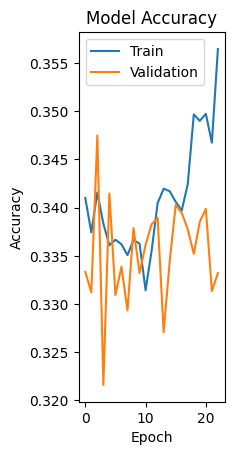

In [53]:
# Plot training & validation accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

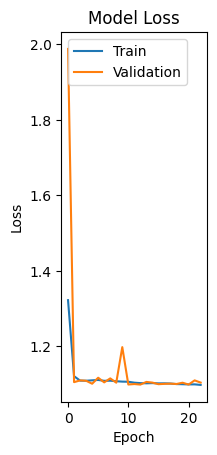

In [54]:
# Plot training & validation loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


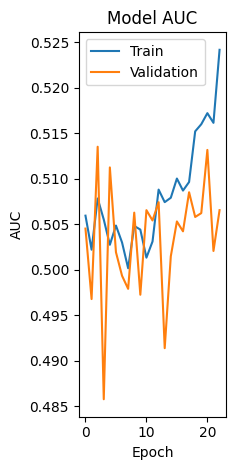

In [55]:
# Plot training & validation AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc_2'])
plt.plot(history.history['val_auc_2'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()


In [56]:
# Make predictions on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


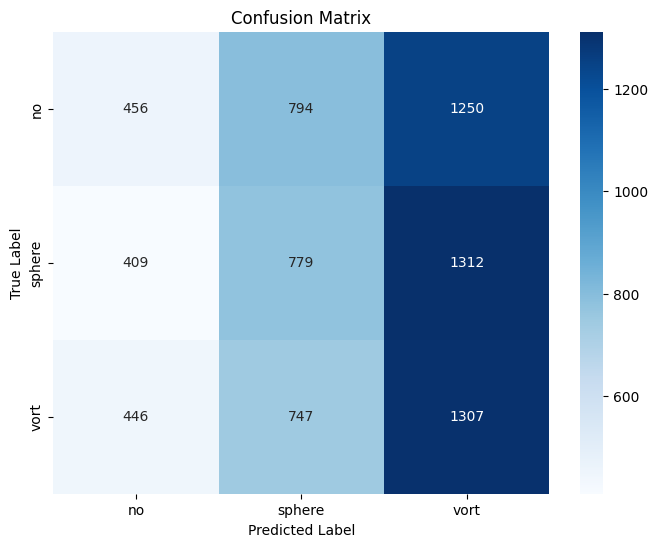

In [57]:
# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['no', 'sphere', 'vort'],
            yticklabels=['no', 'sphere', 'vort'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()


In [58]:
# Classification report
class_names = ['no', 'sphere', 'vort']
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

          no       0.35      0.18      0.24      2500
      sphere       0.34      0.31      0.32      2500
        vort       0.34      0.52      0.41      2500

    accuracy                           0.34      7500
   macro avg       0.34      0.34      0.32      7500
weighted avg       0.34      0.34      0.32      7500



In [59]:
# Calculate and plot ROC curves
# Binarize class labels for ROC curve calculation
y_val_bin = label_binarize(y_val_orig, classes=[0, 1, 2])
n_classes = y_val_bin.shape[1]


In [60]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


In [ ]:

plt.figure(figsize=(10, 8))


In [ ]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')


In [ ]:
# Plot the random guess line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig('roc_curves.png')
plt.show()


In [ ]:
# Calculate micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"Micro-average AUC: {roc_auc['micro']:.4f}")

In [59]:
# Function to visualize sample predictions
def visualize_predictions(X_data, y_true, y_pred, class_names, num_samples=5):
    # Get random indices
    indices = np.random.choice(range(len(X_data)), num_samples, replace=False)
    
    plt.figure(figsize=(15, 3 * num_samples))
    for i, idx in enumerate(indices):
        # Get the image and true/predicted labels
        img = X_data[idx]
        true_label = np.argmax(y_true[idx])
        pred_label = np.argmax(y_pred[idx])
        
        # Get prediction confidence
        pred_confidence = y_pred[idx][pred_label]
        
        # Display the image
        plt.subplot(num_samples, 1, i + 1)
        
        # Handle different channel configurations
        if img.shape[-1] == 1:  # Grayscale
            plt.imshow(img.squeeze(), cmap='gray')
        else:  # RGB or other multi-channel
            plt.imshow(img)
            
        # Add title with true and predicted labels
        title = f"True: {class_names[true_label]}, Predicted: {class_names[pred_label]} (Confidence: {pred_confidence:.2f})"
        if true_label == pred_label:
            plt.title(title, color='green')
        else:
            plt.title(title, color='red')
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png')
    plt.show()


TypeError: Invalid shape (1, 150, 150) for image data

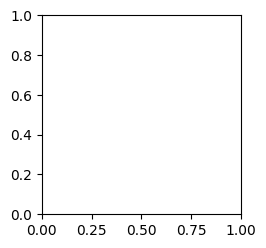

In [60]:
visualize_predictions(X_val, y_val, y_pred, class_names)